# Kingdom Classifier

## Imports & Global Variables

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
arch = models.resnet34
tfms = get_transforms(do_flip=True, flip_vert=True)
image_size = 224
batch_size = 16
device = torch.device('cuda:0')

## Method 1 - Using Folder Names for Labels

### ImageList

In [63]:
path = Path("data1")
data = (ImageList.from_folder(path)
      .split_by_folder()
      .label_from_folder()
      .transform(tfms, size=image_size)
      .databunch(bs=batch_size)
      .normalize(imagenet_stats))

ImageDataBunch;

Train: LabelList (300 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
animal,animal,animal,animal,animal
Path: data1;

Valid: LabelList (115 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
animal,animal,animal,animal,animal
Path: data1;

Test: None

### ImageDataBunch

In [9]:
path = Path("data1")
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=image_size, device=device, bs=batch_size)
data.normalize(imagenet_stats)

## Method 2 - Using Filenames for Labels

In [4]:
path = Path("data2")
path_img = path/"images"
fnames = get_image_files(path_img)
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=tfms, size=image_size, device=device)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (424 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
animal,animal,animal,animal,animal
Path: data2\images;

Valid: LabelList (105 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
animal,fungi,plant,plant,fungi
Path: data2\images;

Test: None

## Method 3 - Using a CSV for Labels

In [12]:
path = Path("")
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,data1/train/animal/animal_001.jpg,animal
1,data1/train/animal/animal_002.jpg,animal
2,data1/train/animal/animal_003.jpg,animal
3,data1/train/animal/animal_004.jpg,animal
4,data1/train/animal/animal_005.jpg,animal


In [13]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=image_size, bs=batch_size, device=device)

## Inspect Data

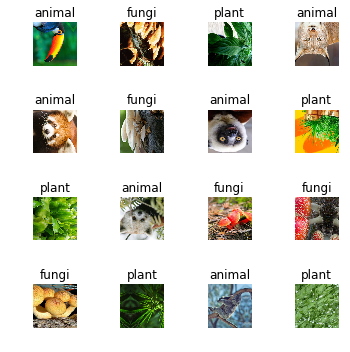

In [14]:
data.show_batch(rows=4, figsize=(5,5))

## Analyze Learning Rate

In [18]:
learn = cnn_learner(data, arch, metrics=error_rate)

In [ ]:
learn.lr_find()

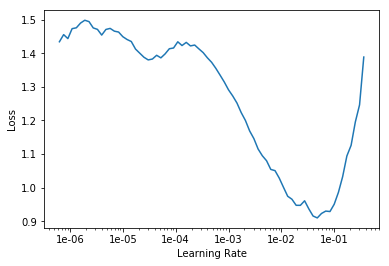

In [21]:
learn.recorder.plot()

## Train

In [19]:
lr = 0.001
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.153330,0.408432,0.066667,01:33
1,0.690567,0.144687,0.028571,01:32
2,0.475878,0.104397,0.038095,01:35
3,0.367457,0.094440,0.038095,01:34
4,0.319537,0.090314,0.028571,01:36


In [24]:
learn.save('method-3-stage-1')

## Analyze Results

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

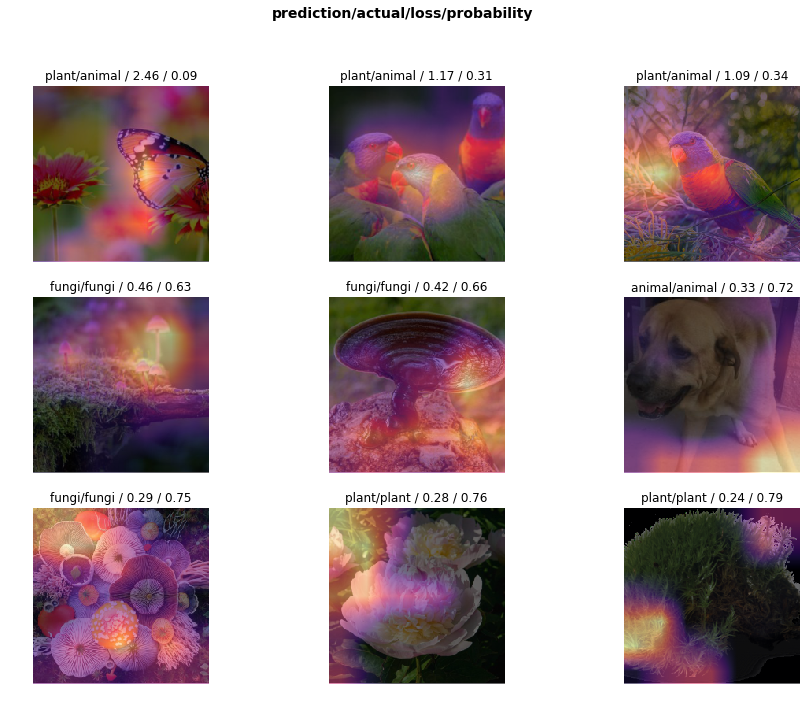

In [21]:
interp.plot_top_losses(9, figsize=(15,11))
# prediction/actual / loss / probability of actual

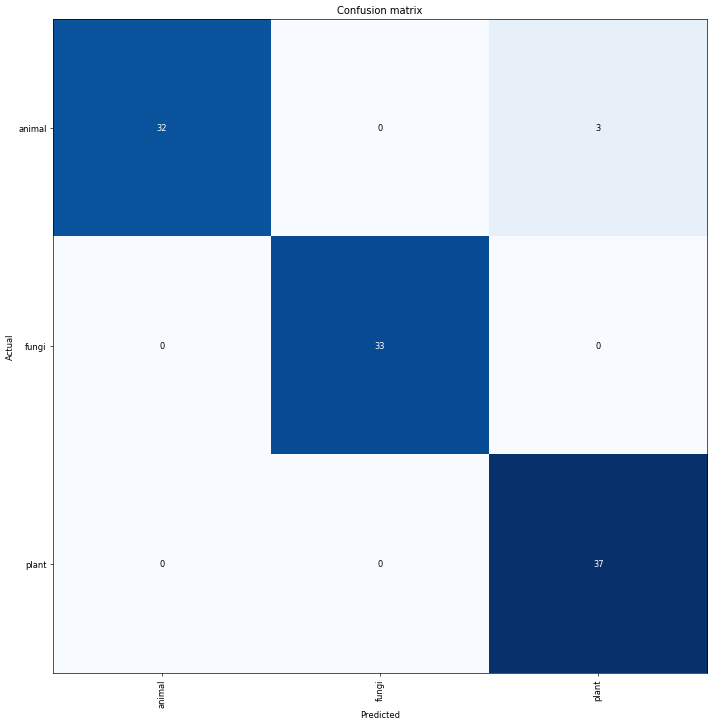

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
interp.most_confused(min_val=1)
# actual, predicted, number of occurrences

[('animal', 'plant', 3)]

## Fine-tuning

In [25]:
learn.unfreeze()

### Try More Training

In [26]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.324922,0.220475,0.095238,01:30


### Analyze Learning Rate

In [27]:
learn.load('method-3-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (424 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
animal,animal,animal,animal,animal
Path: .;

Valid: LabelList (105 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
plant,fungi,animal,animal,fungi
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


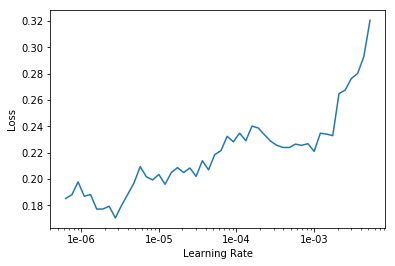

In [29]:
learn.recorder.plot()

In [30]:
learn.unfreeze()

learn.fit_one_cycle(2, max_lr=slice(1e-06, 1e-04))
# slice = increases learning rate from arg1 to arg2 on earlier layers to later layers
# It's the last layers that we're wanting to primarily train

epoch,train_loss,valid_loss,error_rate,time
0,0.235191,0.092273,0.038095,01:29
1,0.209396,0.088309,0.038095,01:30


In [31]:
learn.fit_one_cycle(2, max_lr=slice(1e-06, 1e-04))

epoch,train_loss,valid_loss,error_rate,time
0,0.186520,0.093339,0.028571,01:32
1,0.192844,0.089565,0.028571,01:33
